In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'mean'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Mexican Gothic, Moreno-Garcia",403.077166,14.395613,23.793811,28
Azure Functions Core Tools,335.283307,19.722547,35.083159,17
Node.js and Vite,1541.477305,37.597007,58.915685,41
Django,1523.134121,38.078353,53.991371,40
OAuth 2.0 RFC6749,78.906546,39.453273,47.549932,2
Azure Files Documentation,3037.006136,50.616769,149.782435,60
CCH Tax Forms Project,1231.638762,58.649465,132.898994,21
Active Directory and Azure Files,2180.062726,58.920614,104.594684,37
Python + Oauth2.0,1554.691452,67.595281,148.246921,23
Accounting,1162.517056,68.383356,128.470092,17


# Histogram

sum of ages: ~54199.59


<Axes: >

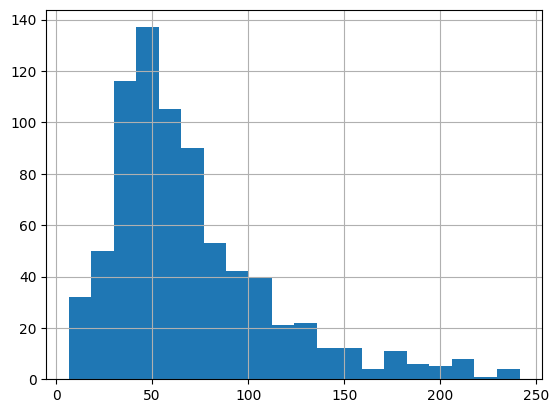

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~54199.59


<Axes: >

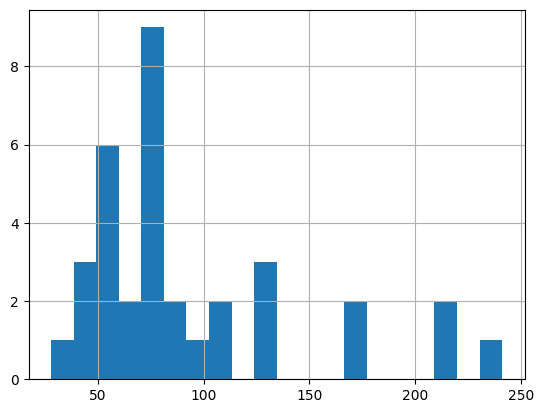

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='PnP PowerShell']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 771
Total card age: 54199.59


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
213,OAuth 2.0 RFC6749,OAuth defines four roles:\n\n resource owner...,cf40615cb8db6d57638ce918affc0082,47.549932,39.453273,-47.549932,78.906546,0.452677,2,0,0,-47.549932
477,OAuth 2.0 RFC6749,Access tokens\n are issued to third-party cl...,aa6002231b9f45492bb6097a7b6045cf,31.356614,39.453273,-47.549932,78.906546,0.452677,2,1,0,-31.356614
6,VMWare,DirectPath I/O\n\nA feature in VMware ESXi tha...,287a455db958ae907155d77816efe340,192.574565,103.720458,-192.574565,622.322751,0.160423,6,0,0,-192.574565
274,VMWare,VMFS (Virtual Machine File System)\n\nA high-p...,4714701a98c9792497b7296b56747546,122.986343,103.720458,-192.574565,622.322751,0.160423,6,1,0,-122.986343
535,VMWare,VMware Horizon\n\nA VMware product used for Vi...,e3daf2b77d53053ed431bba3138c4d44,103.984290,103.720458,-192.574565,622.322751,0.160423,6,2,0,-103.984290
7,VMWare,vSphere Distributed Switch (vDS)\n\nA virtual ...,74a01c534b2d9869c7a365b9456d091f,94.421672,103.720458,-192.574565,622.322751,0.160423,6,3,0,-94.421672
275,VMWare,"Resource Pool\n\nA logical grouping of CPU, me...",95671914b1c0b932803a949740c1b64b,58.840588,103.720458,-192.574565,622.322751,0.160423,6,4,0,-58.840588
258,C# Basics,"C#: Delegates are type-safe function pointers,...",09087e1f0b7050d2f913fb04e5a34db9,179.319464,99.751595,-179.319464,798.012757,0.012411,8,0,0,-179.319464
520,C# Basics,How do you handle exceptions in C#?\n\nC#:\ntr...,a10dc4dbcc23fb173e82fc44a9d23e29,155.778265,99.751595,-179.319464,798.012757,0.012411,8,1,0,-155.778265
259,C# Basics,What are the key access modifiers in C#?\n\npu...,bd09423f2706aac94103024c01fb433a,127.699575,99.751595,-179.319464,798.012757,0.012411,8,2,0,-127.699575



## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(1114.51130792129)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
15,PnP PowerShell,App-Only Authentication\nA mode where applicat...,12d9bc97a1e6f53d3b7295eb85274bad,241.184401,93.174008,-241.184401,3167.916270,0.827368,34,0,0,-241.184401
69,Terraform Codebox,A cloud-init.yaml.tpl file is a template for p...,e86be4b765ffee839b385a1a96ac3db1,239.594090,84.589132,-239.594090,3975.689202,0.401474,47,0,0,-239.594090
102,Power BI,Why can’t you reference a newly added column a...,a550364578e3469f2990bdec6904efc0,233.773623,81.843103,-233.773623,2618.979306,0.748862,32,0,0,-233.773623
49,CCH Axcess,Security groups with any level of rights can b...,78f3ef96be8d308e501c9a70a0bc0c56,231.003181,89.993034,-231.003181,5219.595993,0.386996,58,0,0,-231.003181
316,CCH Axcess,Enable AutoText descriptions\nAllows you to cr...,5d78f7e45fe2c0dbf42b9c87b93c2224,225.159458,89.993034,-231.003181,5219.595993,0.386996,58,1,0,-225.159458
335,Terraform Codebox,Azure Files can be used to persist your coding...,9775a34a34e3610d8ddc43c1e0b44268,217.105994,84.589132,-239.594090,3975.689202,0.401474,47,1,0,-217.105994
126,Python,Q:\nWhat method do you call to parse the comma...,58c3e5284b8e017e25b1fe16b13cb52b,215.179057,73.037289,-215.179057,4382.237353,0.086165,60,0,0,-215.179057
27,Azure Compute Gallery,"Managed Image – A single, region-bound image s...",4099811ce9ab63014bfbe9d3999b3e32,214.764399,92.244979,-214.764399,1660.409620,0.512107,18,0,0,-214.764399
283,PnP PowerShell,REST API Endpoints\nSpecific URLs used to acce...,b12f5012328f32a6c689485970705806,213.440505,93.174008,-241.184401,3167.916270,0.827368,34,1,0,-213.440505
543,PnP PowerShell,Environment Variables\nVariables that are set ...,e888c7c4c00e3b122457c3d900fd4e77,213.041919,93.174008,-241.184401,3167.916270,0.827368,34,2,0,-213.041919


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 70.298'